# Задание 10.2 (HW-02) 
# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

Крючков А.В.

Группа DSPR-178

## Задача:

 HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы. Исследовать данные и сделайть выводы по полученным результатам. Подкрепить свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

## Цели анализа:

Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:

Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


In [377]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels import stats as sms

# 1 Загрузка и обработка данных

In [378]:
data = pd.read_csv('data/ds_salaries.csv')
data

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


Описательный анализ данных

In [379]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None

В датасете нет пропусков, 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [380]:
display(f'Число найденных дубликатов: {data[data.duplicated].shape[0]}')

'Число найденных дубликатов: 0'

Типы данных столбца 'work_year' необходимо задать как datetime. Остальные типы данных заданы корректно.

При дальнейших расчетах не понадобится неинформативный признак 'Unnamed: 0', избыточные 'salary', 'salary_currency', так как есть признак 'salary_in_usd' приведенный к единой валюте.

In [381]:
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis = 1)
data['work_year'] = pd.to_datetime(data['work_year'], format='%Y')

Основные статистические характеристики для каждого из признаков.

In [382]:
display(data.describe())

,work_year,salary_in_usd,remote_ratio
count,607,607.000000,607.00000
mean,2021-05-28 19:20:03.953871616,112297.869852,70.92257
min,2020-01-01 00:00:00,2859.000000,0.00000
25%,2021-01-01 00:00:00,62726.000000,50.00000
50%,2022-01-01 00:00:00,101570.000000,100.00000
75%,2022-01-01 00:00:00,150000.000000,100.00000
max,2022-01-01 00:00:00,600000.000000,100.00000
std,NaN,70957.259411,40.70913


In [383]:
data.describe(include=['object'])

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,607,607,607,607,607,607
unique,4,4,50,57,50,3
top,SE,FT,Data Scientist,US,US,M
freq,280,588,143,332,355,326


Классификация признаков:

work_year - категориальный;

salary_in_usd - числовой;

experience_level - категориальный;

employment_type - категориальный;

job_title - категориальный;

employee_residence - категориальный;

remote_ratio - категориальный;

company_location - категориальный;

company_size - категориальный.

# 2 Разведывательный анализ данных

## 2.1 Визуальный анализ данных

### 2.1.1 Распределение зарплат по всем клиентам

Text(0.5, 1.0, 'Распределение зарплат для всех специалистов')

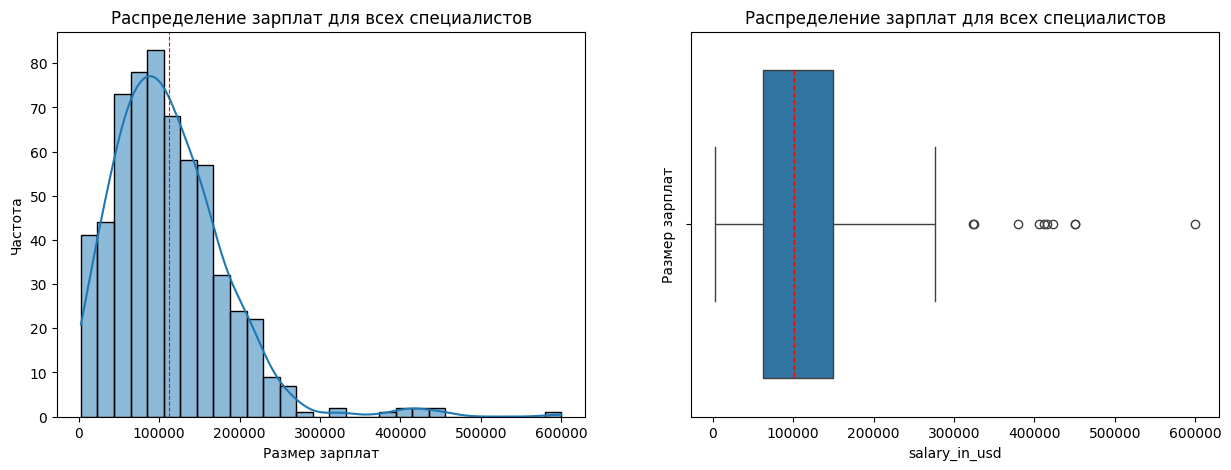

In [384]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплат', ylabel='Частота')
axes[0].set_title('Распределение зарплат для всех специалистов')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплат')
axes[1].set_title('Распределение зарплат для всех специалистов')

In [385]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат']
data_agg

,Размер зарплат
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


Распределение зарплат отлично от нормального, имеются выбросы.

### 2.1.1 Размер зарплаты в зависимости от опыта работы

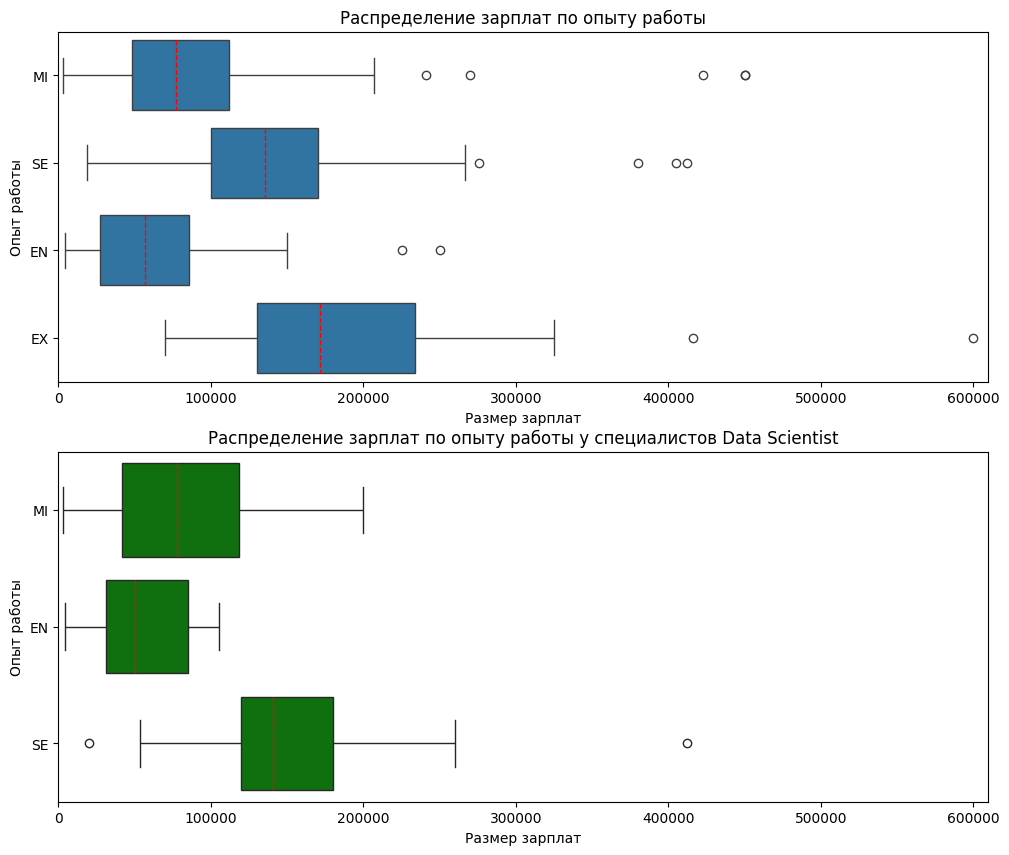

In [386]:
# составим таблицу по названиям специальностей Data Scientist.
data_ds = data[data['job_title'] == 'Data Scientist']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.2)

ax_1 = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
ax_1.set(xlabel='Размер зарплат', 
        ylabel='Опыт работы', 
        title = 'Распределение зарплат по опыту работы', xlim = [0, max(data['salary_in_usd'])+10000])


ax_2 = sns.boxplot(data_ds, x='salary_in_usd', y='experience_level', orient='h', color='green', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
ax_2.set(xlabel='Размер зарплат', 
        ylabel='Опыт работы', 
        title = 'Распределение зарплат по опыту работы у специалистов Data Scientist', 
        xlim = [0, max(data['salary_in_usd'])+10000])

plt.show()

In [387]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от опыта работы')
data_agg

Зарплата в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.0,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.5,171437.5,233750.00,600000.0
MI,213.0,87996.06,63901.06,2859.0,48000.0,76940.0,112000.00,450000.0
SE,280.0,138617.29,57691.98,18907.0,100000.0,135500.0,170000.00,412000.0


In [388]:
data_agg_ds = data_ds.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от опыта работы у специалистов Data Scientist')
data_agg_ds

Зарплата в зависимости от опыта работы у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


Распределения зарплат для разных уровней опыта показывет, что медианные и максимальные значения растут от увеличения опыта. Что в принципе ожидаемо. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

### 2.1.2 Размер зарплаты в зависимости от года

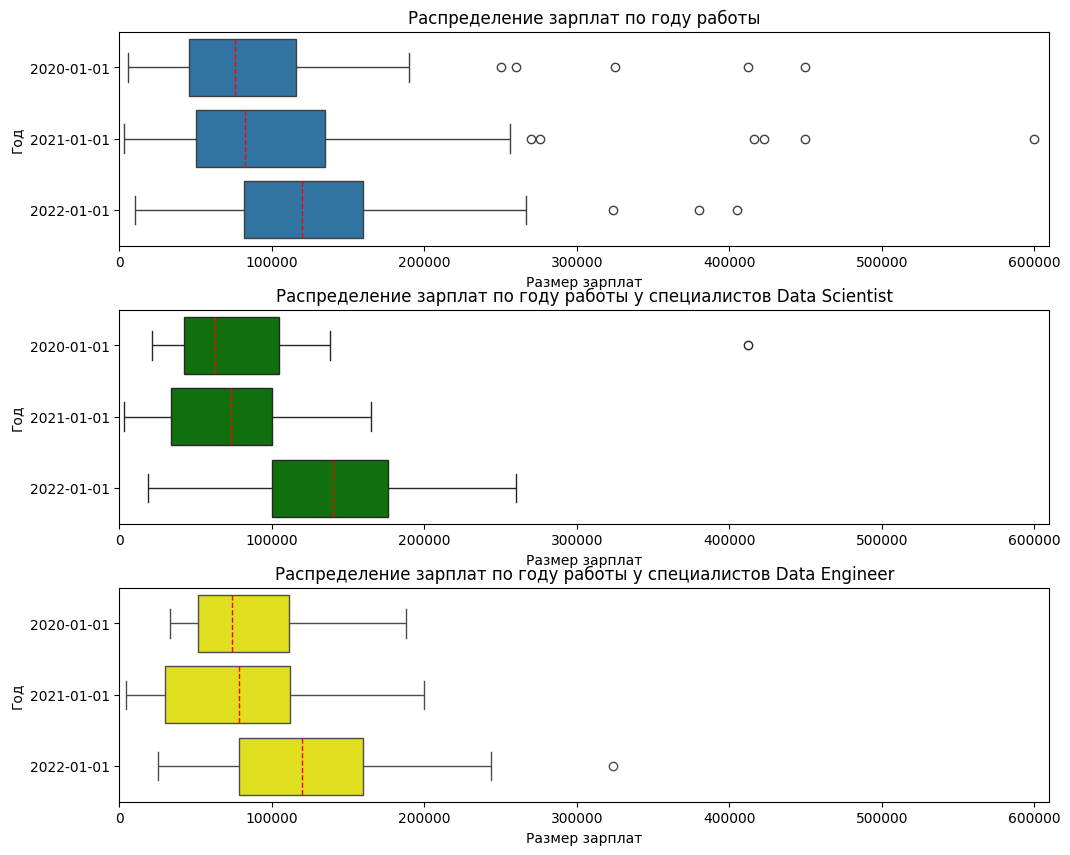

In [389]:
# составим таблицу по названиям специальностей Data Engineer.
data_de = data[data['job_title'] == 'Data Engineer']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)

ax_1 = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
ax_1.set(xlabel='Размер зарплат', 
         ylabel='Год', 
         title = 'Распределение зарплат по году работы', 
         xlim = [0, max(data['salary_in_usd'])+10000])

ax_2 = sns.boxplot(data_ds, x='salary_in_usd', y='work_year', orient='h', color='green', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
ax_2.set(xlabel='Размер зарплат',
        ylabel='Год',
        title = 'Распределение зарплат по году работы у специалистов Data Scientist',
        xlim = [0, max(data['salary_in_usd'])+10000])

ax_3 = sns.boxplot(data_de, x='salary_in_usd', y='work_year', orient='h', color='yellow', medianprops={"color": "red", "linestyle": '--'}, ax=axes[2])
ax_3.set(xlabel='Размер зарплат',
        ylabel='Год', 
        title = 'Распределение зарплат по году работы у специалистов Data Engineer', 
        xlim = [0, max(data['salary_in_usd'])+10000])

plt.show()

In [390]:
data_agg_2 = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от года работы')
data_agg_2

Зарплата в зависимости от года работы


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020-01-01,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021-01-01,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022-01-01,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


In [391]:
data_agg_2_ds = data_ds.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от года работы у специалистов Data Scientist')
data_agg_2_ds

Зарплата в зависимости от года работы у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020-01-01,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021-01-01,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022-01-01,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


In [392]:
data_agg_2_de = data_de.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от года работы у специалистов Data Engineer')
data_agg_2_de

Зарплата в зависимости от года работы у специалистов Data Engineer


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020-01-01,11.0,88162.00,46473.12,33511.0,51320.5,74130.0,111436.00,188000.0
2021-01-01,32.0,83202.53,52926.53,4000.0,29940.0,78416.5,111831.25,200000.0
2022-01-01,89.0,126375.70,55954.40,25000.0,78526.0,120000.0,160000.00,324000.0


Распределения зарплат для 2020, 2021, 2022 годов показывают, что медианные и максимальные значения растут от года в год. Что ожидаемо. 

У специалистов Data Scientist медианные зарплаты в 2020 году были меньше, чем у Data Engineer, в 2021 году примерно равные, в 2022 году стали больше.

Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

### 2.1.3 Размер зарплаты в зависимости от типа трудоустройства

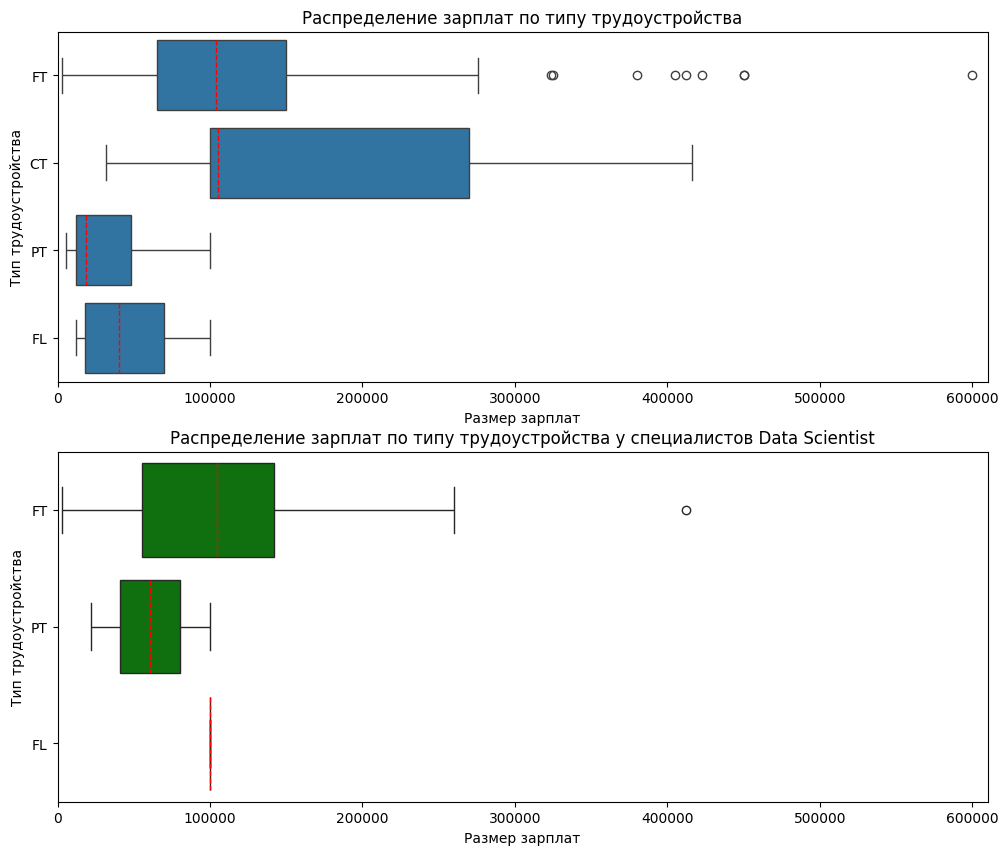

In [393]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.2)

ax_1 = sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
ax_1.set(xlabel='Размер зарплат', ylabel='Тип трудоустройства', title = 'Распределение зарплат по типу трудоустройства', xlim = [0, max(data['salary_in_usd'])+10000])

ax_2 = sns.boxplot(data_ds, x='salary_in_usd', y='employment_type', orient='h', color='green', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
ax_2.set(xlabel='Размер зарплат', ylabel='Тип трудоустройства', title = 'Распределение зарплат по типу трудоустройства у специалистов Data Scientist', xlim = [0, max(data['salary_in_usd'])+10000])

plt.show()

In [394]:
data_agg_3 = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от типа трудоустройства')
data_agg_3

Зарплата в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.00,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.00,40000.0,70000.0,100000.0
FT,588.0,113468.07,69476.47,2859.0,64962.25,104196.5,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.00,18817.5,48370.0,100000.0


In [395]:
data_agg_3_ds = data_ds.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от типа трудоустройства')
data_agg_3_ds

Зарплата в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,140.0,108922.79,64372.43,2859.0,55490.00,104796.0,141975.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


Распределения зарплат в зависимости от типа трудоустройства различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

### 2.1.4 Размер зарплаты в зависимости от страны проживания сотрудника 

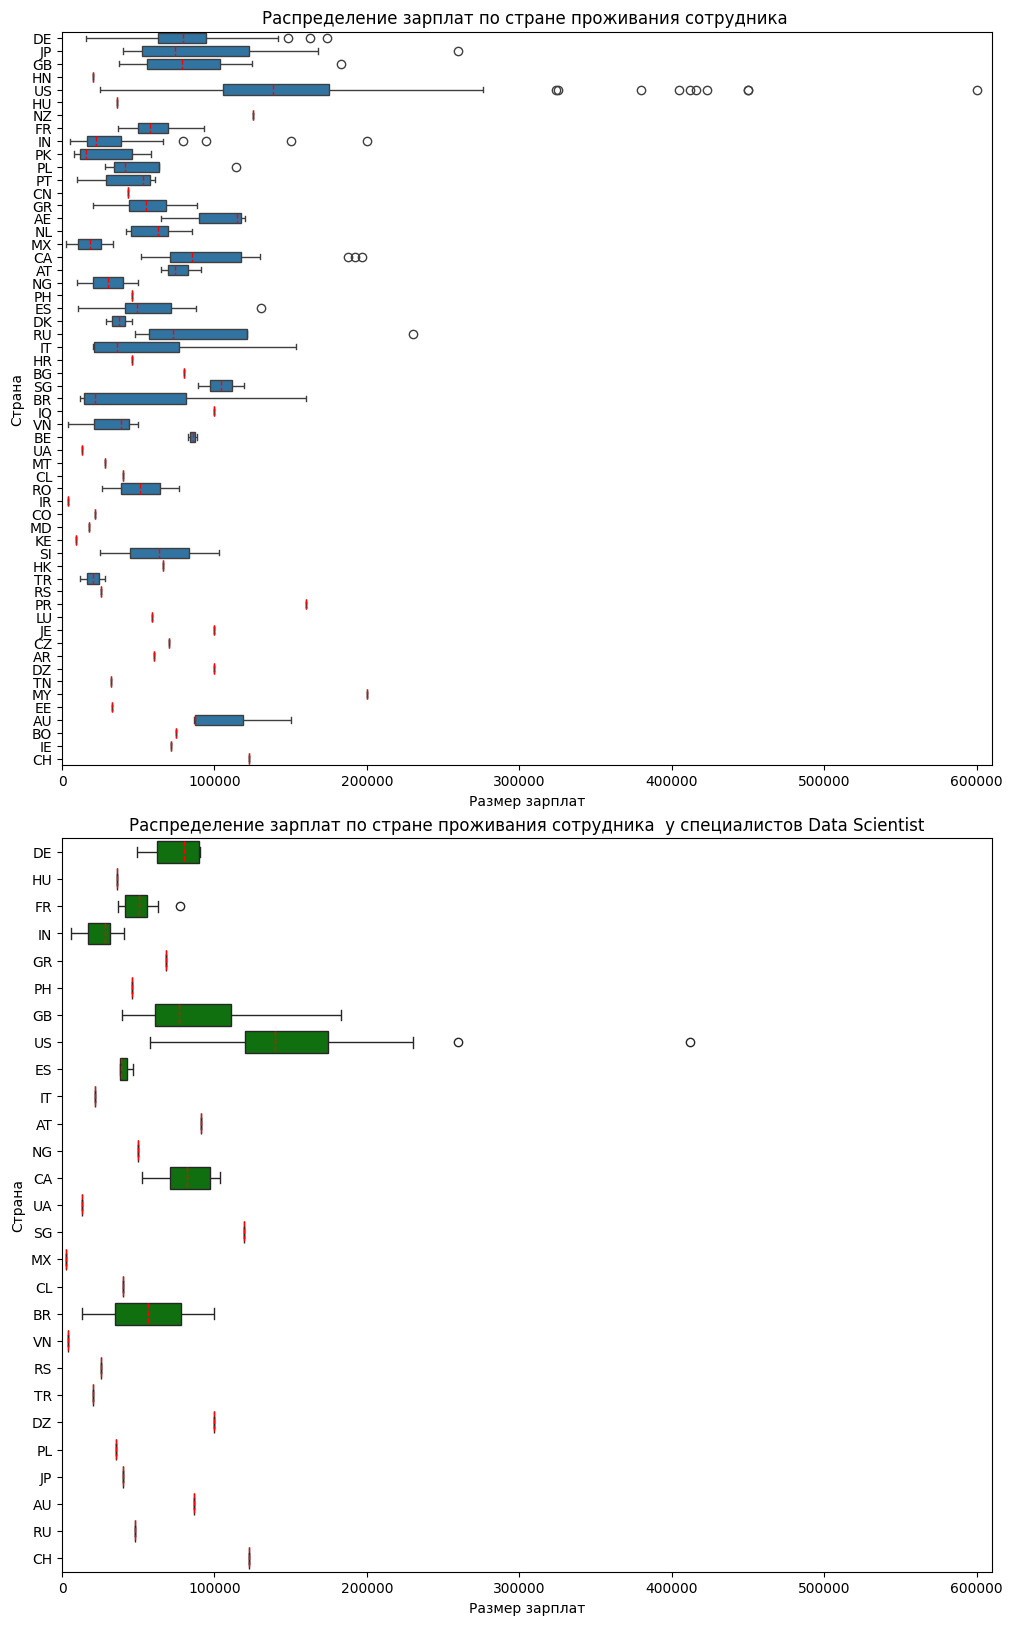

In [396]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 20))
plt.subplots_adjust(hspace=0.1)

ax_1 = sns.boxplot(data, x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
ax_1.set(xlabel='Размер зарплат', ylabel='Страна', title = 'Распределение зарплат по стране проживания сотрудника ', xlim = [0, max(data['salary_in_usd'])+10000])

ax_2 = sns.boxplot(data_ds, x='salary_in_usd', y='employee_residence', orient='h', color='green', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
ax_2.set(xlabel='Размер зарплат', ylabel='Страна', title = 'Распределение зарплат по стране проживания сотрудника  у специалистов Data Scientist', xlim = [0, max(data['salary_in_usd'])+10000])

plt.show()

In [397]:
data_agg_4 = data.groupby('employee_residence')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от страны проживания сотрудника ')
data_agg_4

Зарплата в зависимости от страны проживания сотрудника 


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
AE,3.0,100000.00,30413.81,65000.0,90000.00,115000.0,117500.00,120000.0
AR,1.0,60000.00,NaN,60000.0,60000.00,60000.0,60000.00,60000.0
AT,3.0,76738.67,13386.02,64849.0,69489.50,74130.0,82683.50,91237.0
AU,3.0,108042.67,36337.91,86703.0,87064.00,87425.0,118712.50,150000.0
BE,2.0,85699.00,4179.00,82744.0,84221.50,85699.0,87176.50,88654.0
BG,1.0,80000.00,NaN,80000.0,80000.00,80000.0,80000.00,80000.0
BO,1.0,75000.00,NaN,75000.0,75000.00,75000.0,75000.00,75000.0
BR,6.0,54634.67,61537.35,12000.0,14402.50,21453.5,81000.00,160000.0
CA,29.0,97085.31,39767.44,52000.0,70912.00,85000.0,117104.00,196979.0


In [398]:
data_agg_4_ds = data_ds.groupby('employee_residence')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от страны проживания сотрудника у специалистов Data Scientist')
data_agg_4_ds

Зарплата в зависимости от страны проживания сотрудника у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
AT,1.0,91237.00,NaN,91237.0,91237.00,91237.0,91237.00,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.00,86703.0,86703.00,86703.0
BR,2.0,56450.50,61588.29,12901.0,34675.75,56450.5,78225.25,100000.0
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.00,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.00,40038.0,40038.00,40038.0
DE,7.0,74773.71,16834.87,49268.0,62096.50,79833.0,89694.00,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.50,38776.0,42792.50,46809.0


Распределения зарплат в зависимости от страны проживания сотрудника различны. Максимальные зарплаты в США, но там же и самый большой размах распределения. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

### 2.1.5 Размер зарплаты в зависимости от объема работы, выполняемой удалённо

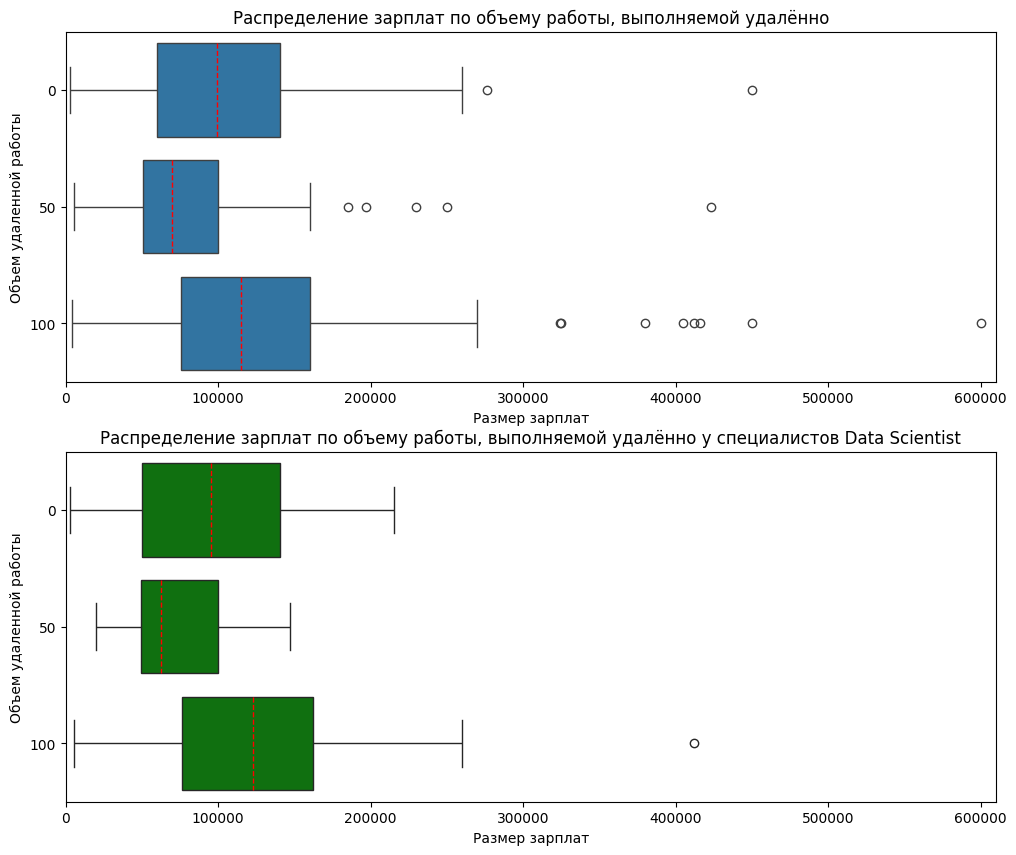

In [399]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.2)

ax_1 = sns.boxplot(data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
ax_1.set(xlabel='Размер зарплат', ylabel='Объем удаленной работы', title = 'Распределение зарплат по объему работы, выполняемой удалённо', xlim = [0, max(data['salary_in_usd'])+10000])


ax_2 = sns.boxplot(data_ds, x='salary_in_usd', y='remote_ratio', orient='h', color='green', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
ax_2.set(xlabel='Размер зарплат', ylabel='Объем удаленной работы', title = 'Распределение зарплат по объему работы, выполняемой удалённо у специалистов Data Scientist', xlim = [0, max(data['salary_in_usd'])+10000])

plt.show()

In [400]:
data_agg_5 = data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от объема работы, выполняемой удалённо')
data_agg_5

Зарплата в зависимости от объема работы, выполняемой удалённо


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,127.0,106354.62,67724.54,2859.0,60000.0,99000.0,140400.0,450000.0
50,99.0,80823.03,57353.09,5409.0,50355.0,69999.0,99851.5,423000.0
100,381.0,122457.45,72710.84,4000.0,75774.0,115000.0,160000.0,600000.0


In [401]:
data_agg_5_ds = data_ds.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от объема работы, выполняемой удалённо у специалистов Data Scientist')
data_agg_5_ds

Зарплата в зависимости от объема работы, выполняемой удалённо у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.08,35602.82,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


Распределения зарплат в зависимости от объема работы, выполняемой удалённо различны не на много. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

### 2.1.6 Размер зарплаты в зависимости от страны главного офиса работодателя или филиала по контракту

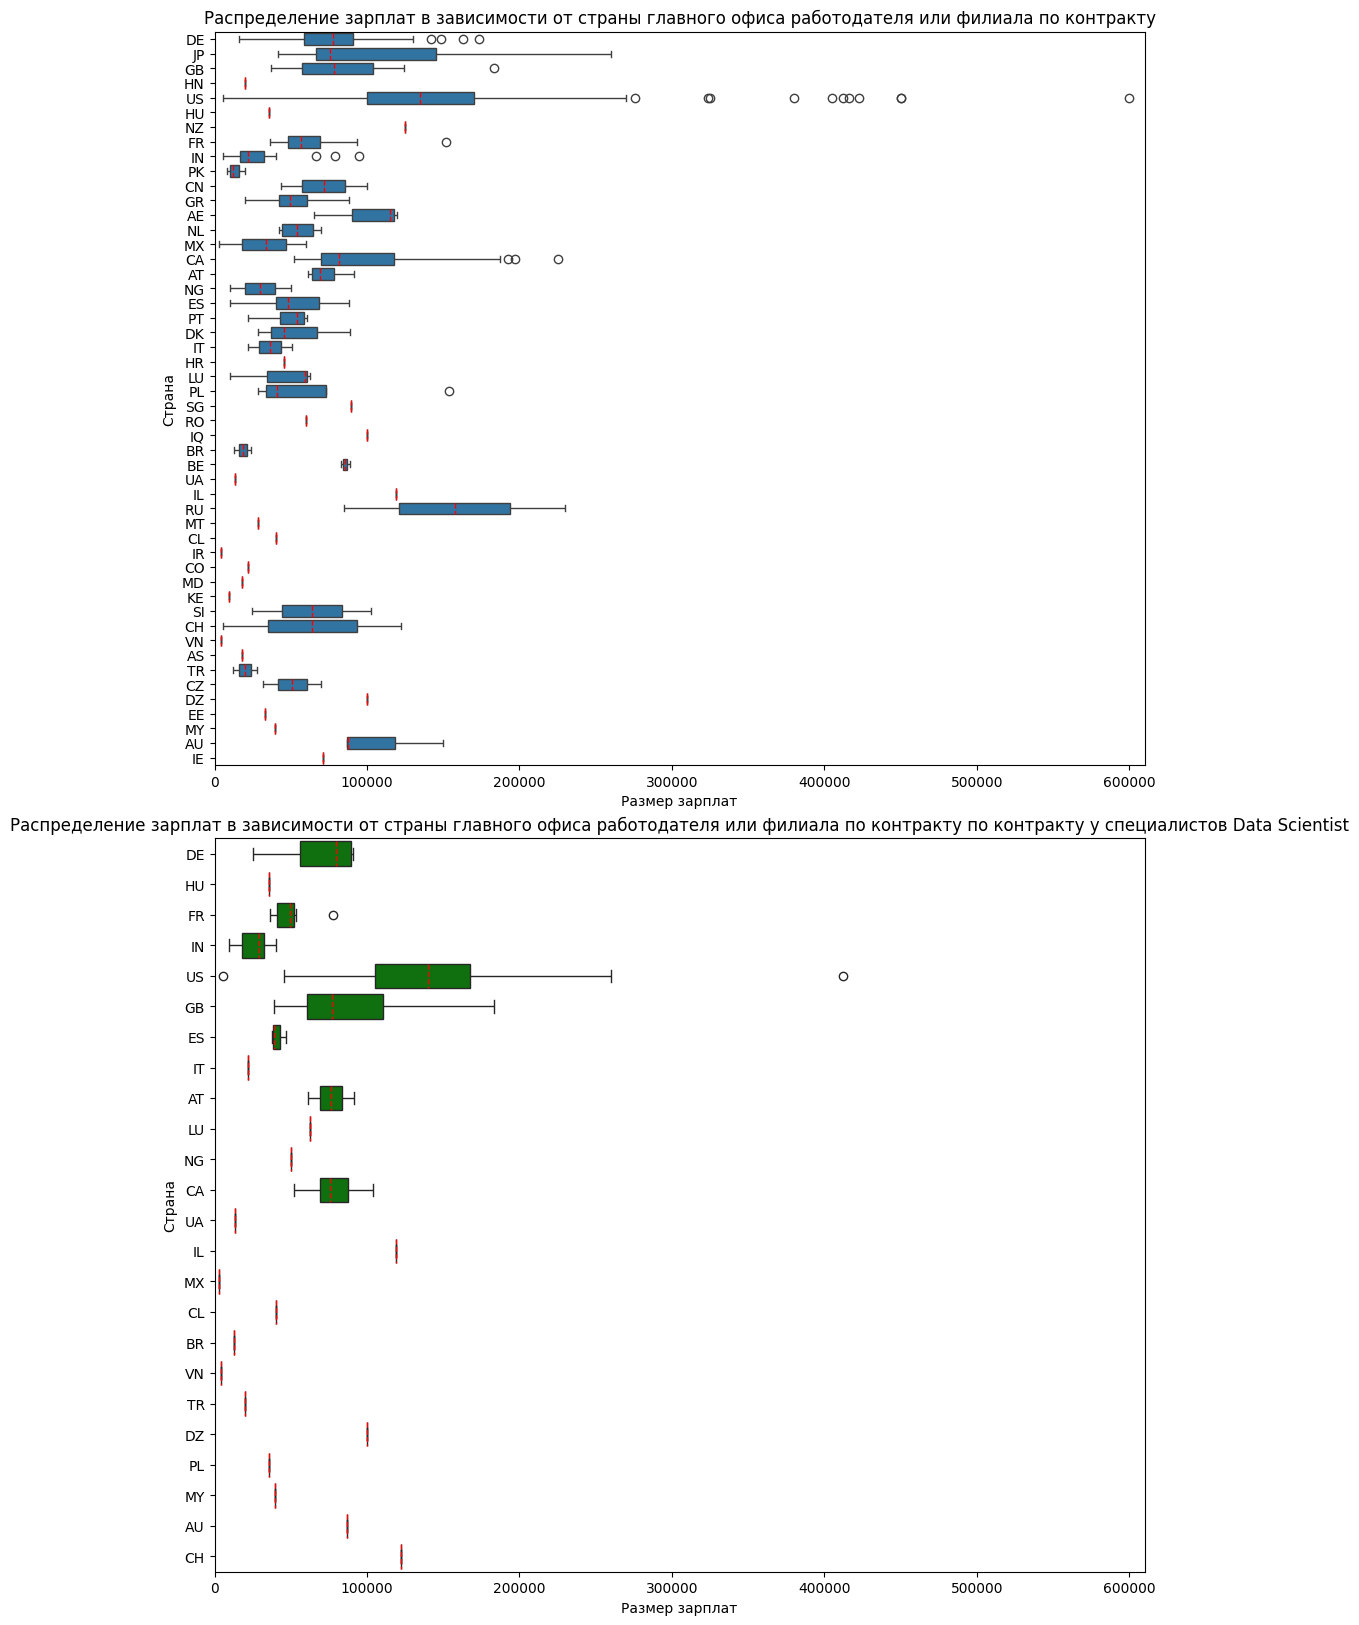

In [402]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 20))
plt.subplots_adjust(hspace=0.1)

ax_1 = sns.boxplot(data, x='salary_in_usd', y='company_location', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
ax_1.set(xlabel='Размер зарплат', ylabel='Страна', title = 'Распределение зарплат в зависимости от страны главного офиса работодателя или филиала по контракту', xlim = [0, max(data['salary_in_usd'])+10000])

ax_2 = sns.boxplot(data_ds, x='salary_in_usd', y='company_location', orient='h', color='green', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
ax_2.set(xlabel='Размер зарплат', ylabel='Страна', title = 'Распределение зарплат в зависимости от страны главного офиса работодателя или филиала по контракту по контракту у специалистов Data Scientist', xlim = [0, max(data['salary_in_usd'])+10000])

plt.show()

In [403]:
data_agg_6 = data.groupby('company_location')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от страны главного офиса работодателя или филиала по контракту')
data_agg_6

Зарплата в зависимости от страны главного офиса работодателя или филиала по контракту


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AE,3.0,100000.00,30413.81,65000.0,90000.00,115000.0,117500.00,120000.0
AS,1.0,18053.00,NaN,18053.0,18053.00,18053.0,18053.00,18053.0
AT,4.0,72920.75,13332.78,61467.0,64003.50,69489.5,78406.75,91237.0
AU,3.0,108042.67,36337.91,86703.0,87064.00,87425.0,118712.50,150000.0
BE,2.0,85699.00,4179.00,82744.0,84221.50,85699.0,87176.50,88654.0
BR,3.0,18602.67,5555.76,12901.0,15904.00,18907.0,21453.50,24000.0
CA,30.0,99823.73,46329.10,52000.0,69730.00,81895.5,117916.25,225000.0
CH,2.0,64114.00,82352.48,5882.0,34998.00,64114.0,93230.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.00,40038.0,40038.00,40038.0


In [404]:
data_agg_6_ds = data_ds.groupby('company_location')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от страны главного офиса работодателя или филиала по контракту у специалистов Data Scientist')
data_agg_6_ds

Зарплата в зависимости от страны главного офиса работодателя или филиала по контракту у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AT,2.0,76352.00,21050.57,61467.0,68909.5,76352.0,83794.50,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.0,86703.0,86703.00,86703.0
BR,1.0,12901.00,NaN,12901.0,12901.0,12901.0,12901.00,12901.0
CA,5.0,77787.00,19301.65,52396.0,69336.0,75774.0,87738.00,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.0,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.0,40038.0,40038.00,40038.0
DE,7.0,69640.14,25045.56,25532.0,55997.0,79833.0,89694.00,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.0,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.5,38776.0,42792.50,46809.0


Распределения зарплат в зависимости от страны главного офиса работодателя или филиала по контракту. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

### 2.1.7 Размер зарплаты в зависимости от числа сотрудников компании

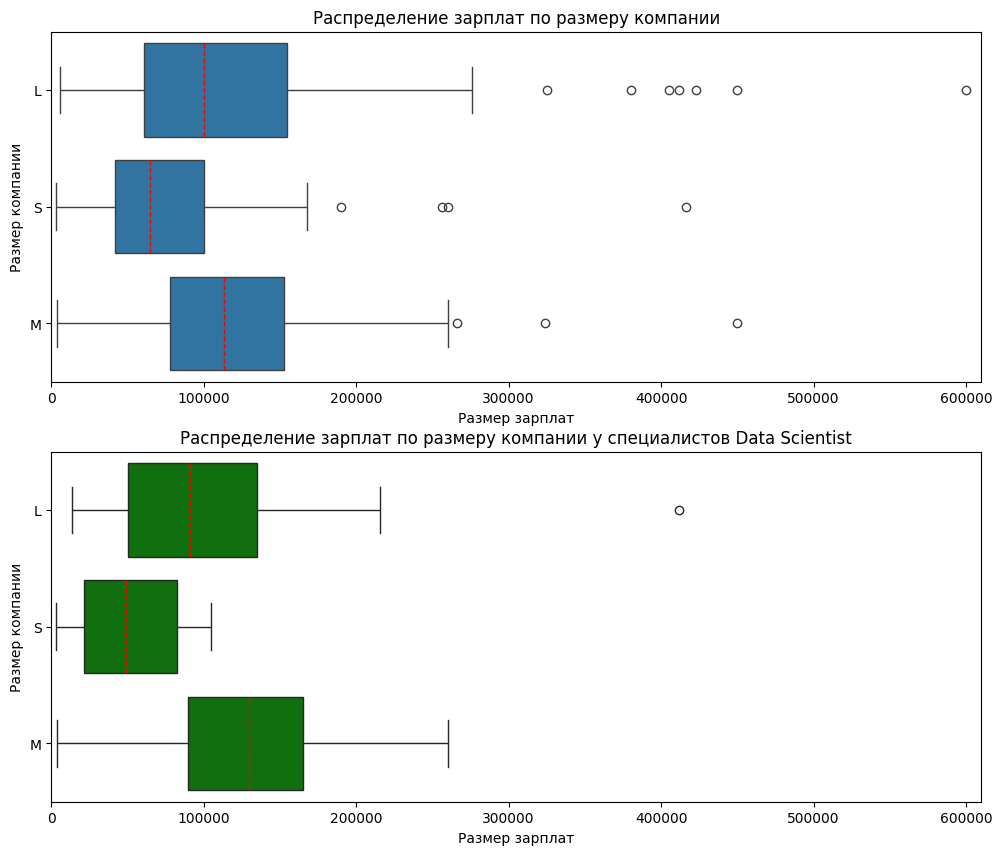

In [405]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.2)

ax_1 = sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
ax_1.set(xlabel='Размер зарплат', ylabel='Размер компании', title = 'Распределение зарплат по размеру компании', xlim = [0, max(data['salary_in_usd'])+10000])

ax_2 = sns.boxplot(data_ds, x='salary_in_usd', y='company_size', orient='h', color='green', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
ax_2.set(xlabel='Размер зарплат', ylabel='Размер компании', title = 'Распределение зарплат по размеру компании у специалистов Data Scientist', xlim = [0, max(data['salary_in_usd'])+10000])

plt.show()

In [406]:
data_agg_7 = data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от числа сотрудников компании')
data_agg_7

Зарплата в зависимости от числа сотрудников компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,198.0,119242.99,86156.74,5882.0,61041.75,100000.0,154600.0,600000.0
M,326.0,116905.47,59287.69,4000.0,78131.50,113188.0,152875.0,450000.0
S,83.0,77632.67,63461.71,2859.0,41943.00,65000.0,100000.0,416000.0


In [407]:
data_agg_7_ds = data_ds.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от числа сотрудников компании у специалистов Data Scientist')
data_agg_7_ds

Зарплата в зависимости от числа сотрудников компании у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Медианные зарплаты как по всем специальностям, так и Data Scientist в маленьких компаниях самые низкие, в больших компаниях немного меньше, чем в компаних среднего размера, но при этом максимальные зарплаты выше.

Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

### 2.1.8 Зависимость размера компании от числа специалистов Data Scientist и Data Engineer

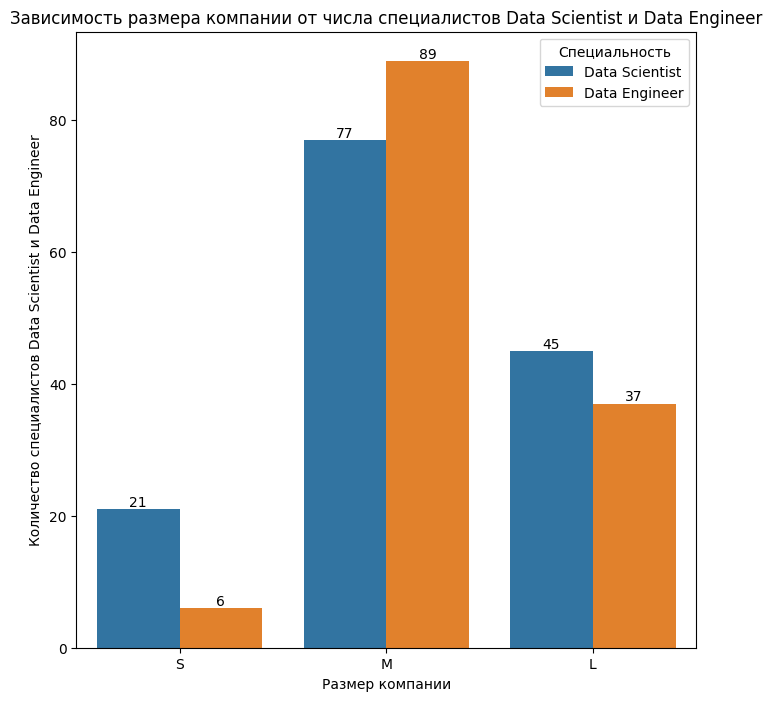

In [408]:
data_ds_en = data[(data['job_title']=='Data Scientist') | (data['job_title']=='Data Engineer')]

fig, axes = plt.subplots(figsize=(8, 8))
ax = sns.countplot(data=data_ds_en, x=data['company_size'], hue='job_title', order = ['S', 'M', 'L'])
ax.set(xlabel='Размер компании', ylabel='Количество специалистов Data Scientist и Data Engineer')
ax.legend(title = 'Специальность')
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])
plt.title('Зависимость размера компании от числа специалистов Data Scientist и Data Engineer')
plt.show()

Число специалистов распределено по размерам компаний неравномерно. В компаниях S с малым числом сотрудников меньшее число специалистов Data Science и Data Engineer.

В компаниях M со средним числом сотрудников - самое большое число специалистов Data Science.

В компаниях L со большим числом сотрудников - среднее число специалистов Data Science.

Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

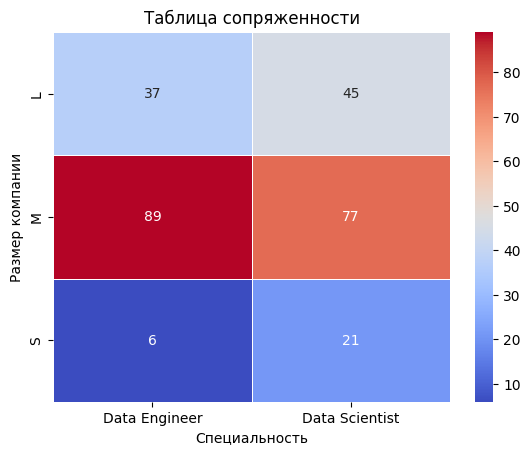

In [409]:
cross_tab = pd.crosstab(index=data_ds_en['company_size'], columns=data_ds_en['job_title'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Специальность', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()

### 2.1.9 Зависимость размера компании от опыта специалистов Data Scientist и Data Engineer

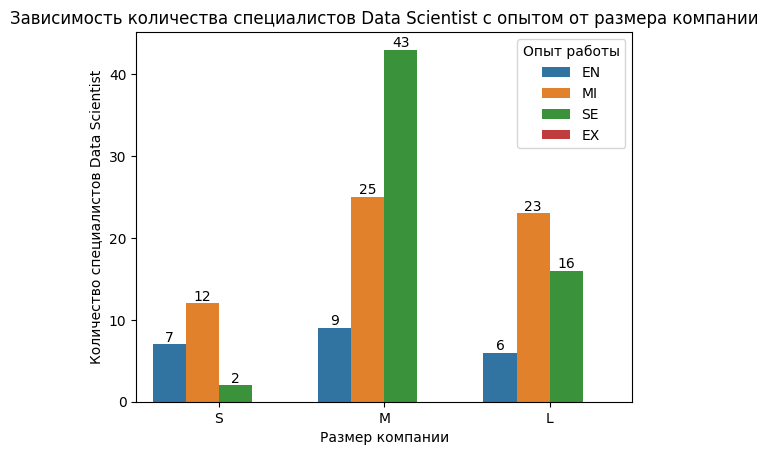

In [410]:

ax = sns.countplot(data=data_ds, x=data['company_size'], hue='experience_level', order = ['S', 'M', 'L'], hue_order = ['EN', 'MI', 'SE', 'EX'])
ax.set(xlabel='Размер компании', ylabel='Количество специалистов Data Scientist')
ax.legend(title = 'Опыт работы')
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])
ax.bar_label(container=ax.containers[2])
plt.title('Зависимость количества специалистов Data Scientist с опытом от размера компании')
plt.show()

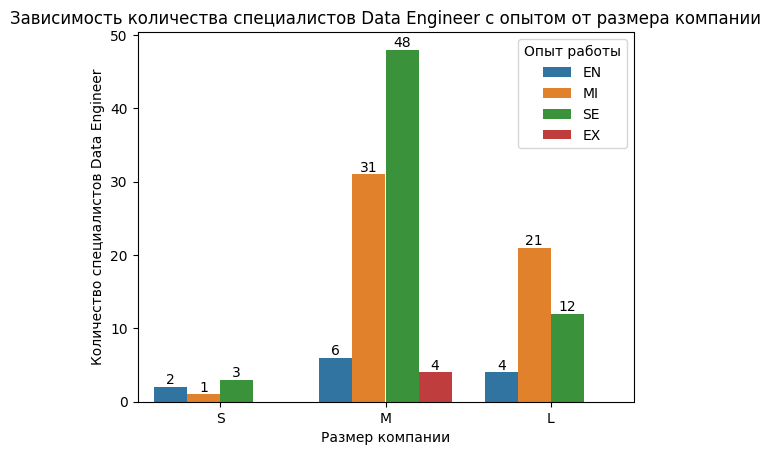

In [411]:
ax = sns.countplot(data=data_de, x=data['company_size'], hue='experience_level', order = ['S', 'M', 'L'], hue_order = ['EN', 'MI', 'SE', 'EX'])
ax.set(xlabel='Размер компании', ylabel='Количество специалистов Data Engineer')
ax.legend(title = 'Опыт работы')
ax.bar_label(container=ax.containers[0])
ax.bar_label(container=ax.containers[1])
ax.bar_label(container=ax.containers[2])
ax.bar_label(container=ax.containers[3])
plt.title('Зависимость количества специалистов Data Engineer с опытом от размера компании')
plt.show()

Медианные зарплаты как по всем специальностям, так и Data Scientist в маленьких компаниях самые низкие, в больших компаниях немного меньше, чем в компаних среднего размера, но при этом максимальные зарплаты выше.

Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

Больше всего специалистов Data Scientist уровня Senior в компаниях средненим числом работавших. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе проведём статистическое тестирование.

## 2.2 Статистический анализ данных

In [412]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


In [413]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### 2.2.1  Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Разобъем задачу на две подзаадчи:

-сравнение зарплат специалистов Data Scientist в 2020г и 2021;

-сравнение зарплат специалистов Data Scientist в 2021г и 2022г.

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [414]:
salary_2020 = data_ds.loc[data['work_year'] == '2020', 'salary_in_usd']
salary_2021 = data_ds.loc[data['work_year'] == '2021', 'salary_in_usd']
salary_2022 = data_ds.loc[data['work_year'] == '2022', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020 года:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021 года:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022 года:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Для 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022 года:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


#### 2.2.1.1 Cравнение зарплат специалистов Data Scientist в 2020г и 2021г.
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат для специалистов Data Scientist в 2021 ($μ_2$) статистически меньше или равен зарплате в 2020 ($μ_1$) году.

$$ H_0 : μ_2 <= μ_1$$

*Альтернативная гипотеза* ($H_1$): размер зарплат для специалистов Data Scientist в 2021 ($μ_2$) статистически больше зарплате в 2020 ($μ_1$) году.
$$ H_1 : μ_2 > μ_1$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. (Так как в одном случае из выборки распределение отлично от норамального, то в целом для группы принимаем распределение отличное от нормального).

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.


**Проведём тест**

In [415]:
# проводим тест
_, p = stats.mannwhitneyu(salary_2021, salary_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.685
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Промежуточный вывод: Размер зарплат для специалистов Data Scientist в 2021 ($μ_2$) статистически меньше или равен зарплате в 2020 ($μ_1$) году.**

#### 2.2.1.2 Cравнение зарплат специалистов Data Scientist в 2021г и 2022г.
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат для специалистов Data Scientist в 2022 ($μ_2$) статистически меньше или равен зарплате в 2021 ($μ_1$) году.

$$ H_0 : μ_2 <= μ_1$$

*Альтернативная гипотеза* ($H_1$): размер зарплат для специалистов Data Scientist в 2022 ($μ_2$) статистически больше зарплате в 2021 ($μ_1$) году.
$$ H_1 : μ_2 > μ_1$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий.


**Проведём тест на равенство дисперсий**

In [416]:
print('Тест на равенство дисперсий')
result = stats.levene(salary_2021, salary_2022)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')


Тест на равенство дисперсий
p-value = 0.445
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


Проведем тест на сравнение средних в группах.

In [417]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_2022, salary_2021, alternative='greater', equal_var=True)
decision_hypothesis(p)



Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод: Размер зарплат для специалистов Data Scientist в 2022 ($μ_2$) статистически больше зарплате в 2021 ($μ_1$) году.**

**Вывод: Статистически значимый рост зарплат специалистов Data Scientist:**

**в 2021 году по сравнению с 2020 небыл;** 

**в 2022 году по сравнению с 2021 был.**

### 2.2.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты Data Scientist ($μ_1$) статистически больше либо равен размеру зарплаты Data Engineer ($μ_2$) в 2022 году.

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты Data Scientist ($μ_1$) статистически меньше размеру зарплаты Data Engineer ($μ_2$) в 2022 году.
$$ H_1 : μ_1 < μ_2$$


In [418]:
# значения зарплаты
data_2022 = data[data['work_year'] == '2022']
salary_ds_2022 = data_2022.loc[data_2022['job_title']=='Data Scientist', 'salary_in_usd']
salary_de_2022 = data_2022.loc[data_2022['job_title']=='Data Engineer', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(salary_ds_2022)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(salary_de_2022)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (Так как в одном случае из выборки распределение отлично от норамального, то в целом для группы принимаем распределение отличное от нормального).

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.


**Проведём тест**

In [419]:
# проводим тест
_, p = stats.mannwhitneyu(salary_ds, salary_de, alternative='less')
decision_hypothesis(p)

p-value = 0.234
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод: Размер зарплаты Data Scientist статистически больше либо равен размеру зарплаты Data Engineer в 2022 году.**

### 2.2.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Разобъем задачу на две подзадачи:

- сравнение зарплат специалистов Data Scientist в малых S и средних M компаниях;

- сравнение зарплат специалистов Data Scientist в средних M и больших L компаниях.

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [420]:
salary_s = data_ds.loc[data['company_size'] == 'S', 'salary_in_usd']
salary_m = data_ds.loc[data['company_size'] == 'M', 'salary_in_usd']
salary_l = data_ds.loc[data['company_size'] == 'L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для малых S компаний:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

print('Для средних M компаний:')
result = stats.shapiro(salary_m)
decision_normality(result[1])

print('Для больших L компаний:')
result = stats.shapiro(salary_l)
decision_normality(result[1])

Для малых S компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средних M компаний:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для больших L компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


#### 2.2.3.1 Сравнение зарплат в малых S и средних M компаниях

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат для специалистов Data Scientist в малых S компанихя ($μ_1$) статистически меньше или равен размеру  зарплат в средних M компаниях ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат для специалистов Data Scientist в малых S компанихя ($μ_1$) статистически больше размера зарплат в средних M компаниях ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий.


**Проведём тест на равенство дисперсий**

In [421]:
print('Тест на равенство дисперсий')
result = stats.levene(salary_s, salary_m)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.025
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


Проведем тест на сравнение средних в группах.

In [422]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_s, salary_m, alternative='greater', equal_var=True)
decision_hypothesis(p)


Тест на равенство средних
p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод: Размер зарплат для специалистов Data Scientist в малых S компаниях статистически меньше или равен размеру зарплат в средних M компаниях.**

#### 2.2.3.2 Сравнение зарплат средних M и больших L компаниях

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат для специалистов Data Scientist в средних M компанихя ($μ_1$) статистически меньше или равен размеру  зарплат в больших L компаниях ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат для специалистов Data Scientist в средних M компанихя ($μ_1$) статистически больше размера зарплат в больших L компаниях ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (Так как в одном случае из выборки распределение отлично от норамального, то в целом для группы принимаем распределение отличное от нормального).

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.


**Проведём тест**

In [423]:
# проводим тест
_, p = stats.mannwhitneyu(salary_m, salary_l, alternative='greater')
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод: Размер зарплат для специалистов Data Scientist в средних M компанихя статистически больше размера зарплат в больших L компаниях ($μ_2$).**

### 2.3.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между размером компании и наличием специалистов Data Scientist и Data Engineer нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между размером компании и наличием специалистов Data Scientist и Data Engineer есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Три.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [424]:
# Добавим признак с метками специальностей Data Scientist и Data Engineer
data['ds_de'] = data['job_title'].apply(lambda x: 'Yes' if x=='Data Scientist' or x=='Data Engineer' else 'No')

In [425]:
# составляем таблицу сопряжённости

cross_table = pd.crosstab(data['company_size'], data['ds_de'])

cross_table

ds_de,No,Yes
company_size,,
L,116,82
M,160,166
S,56,27


In [426]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод: между размером компании и наличием специалистов Data Scientist и Data Engineer есть статистически значимая взаимосвязь (признаки зависимы).**

## Итоговые результаты исследования:

1) Ежегодный рост зарплат не наблюдается.

2) Размер зарплаты Data Scientist статистически больше либо равен размеру зарплаты Data Engineer в 2022 году.

3) Размер зарплат для специалистов Data Scientist в малых S компаниях статистически меньше или равен размеру зарплат в средних M компаниях, а в средних M компанихя статистически больше размера зарплат в больших L компаниях.

4) Между размером компании и наличием специалистов Data Scientist и Data Engineer есть статистически значимая взаимосвязь (признаки зависимы).

## 3 Дополнительные исследования 

### 3.1 Зависимость размера зарплаты от опыта специалистов Data Scientist и Data Engineer

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты у специалистов EN ($μ_1$), MI ($μ_2$), SE ($μ_3$) и EX ($μ_4$) одинаковы.

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты у специалистов EN ($μ_1$), MI ($μ_2$), SE ($μ_3$) и EX ($μ_4$) не одинаковы.
$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [427]:
# значения страховых выплат
salary_en = data.loc[data['experience_level']=='EN', 'salary_in_usd']
salary_mi = data.loc[data['experience_level']=='MI', 'salary_in_usd']
salary_se = data.loc[data['experience_level']=='SE', 'salary_in_usd']
salary_ex = data.loc[data['experience_level']=='EX', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для северо-востока:')
result = stats.shapiro(salary_en)
decision_normality(result[1])

print('Для юго-востока:')
result = stats.shapiro(salary_mi)
decision_normality(result[1])

print('Для северо-запада:')
result = stats.shapiro(salary_se)
decision_normality(result[1])

print('Для юго-запада:')
result = stats.shapiro(salary_ex)
decision_normality(result[1])

Для северо-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для северо-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-запада:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


*Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в usd»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [428]:
# проводим тест
_, p = stats.kruskal(salary_en, salary_mi, salary_se, salary_ex)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**
Размер зарплаты у специалистов EN, MI, SE и EX не одинаковы.

### 3.2 Есть ли связь между страной работодателя США, Германия и Британия и числом специалистов Data Scientist и Data Engineer?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между страной работодателя США (US), Германия (GR) и Британия (GB) и числом специалистов Data Scientist или Data Engineer нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между страной работодателя США (US), Германия (GR) и Британия (GB) и числом специалистов Data Scientist или Data Engineer есть взаимосвязь (признаки зависимы).

In [429]:
data_us_gr_gb = data[(data['company_location'] == 'US') | (data['company_location'] == 'GR') | (data['company_location'] == 'GB')]

In [430]:
# составляем таблицу сопряжённости

cross_table_country = pd.crosstab(data_us_gr_gb['company_location'], data_us_gr_gb['ds_de'])

cross_table_country

ds_de,No,Yes
company_location,,
GB,16,31
GR,6,5
US,186,169


In [431]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table_country)
decision_hypothesis(p)

p-value = 0.059
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**
Между страной работодателя США, Германия и Британия и числом специалистов Data Scientist или Data Engineer нет взаимосвязи (признаки независимы)